In [1]:
!apt install ffmpeg
!pip install ffmpeg-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
#@title recording code
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io

import ffmpeg
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [3]:
import numpy as np
import IPython
import scipy.signal as signal
import matplotlib.pyplot as plt
import librosa
from librosa.display import specshow

In [4]:
def plot_spec(data, rate, n_fft=512, hop_length=256, win_length=256, yscale='linear'):
    plt.clf()
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length)))
    specshow(spec, sr=rate, y_axis=yscale, x_axis='time', cmap='viridis')
    plt.colorbar()
    plt.show()

In [5]:
f1 = 25
f2 = 50
N = 10

In [6]:
t = np.linspace(0, 1, 1000)

sig = np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t)

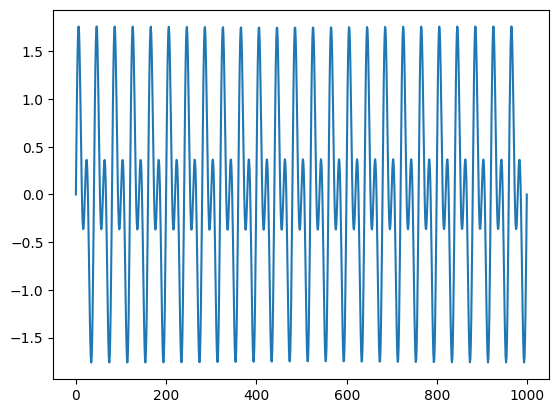

In [7]:
plt.plot(sig)

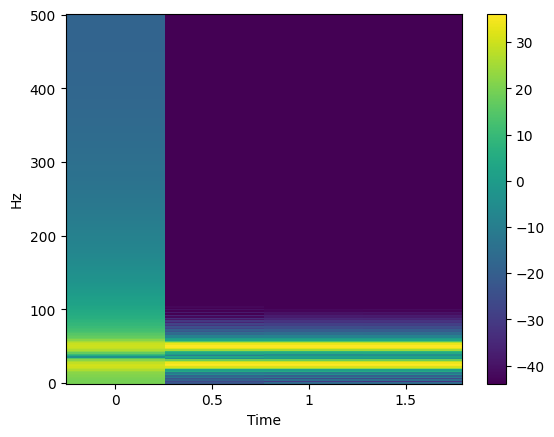

In [8]:
plot_spec(sig, 1000)

In [9]:
sos = signal.butter(50, 35, 'lp', fs=1000, output='sos')

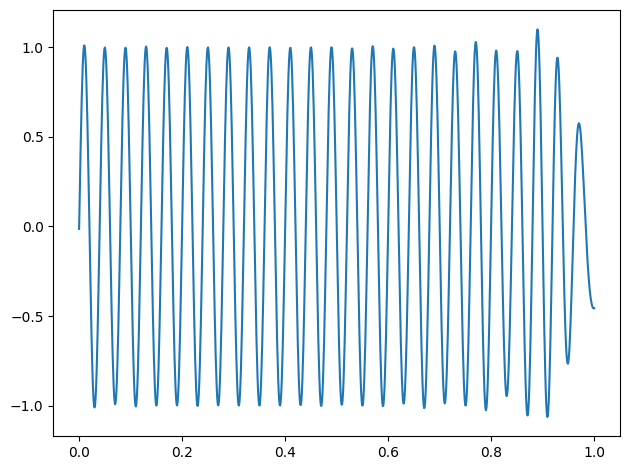

In [10]:
filtered = signal.sosfiltfilt(sos, sig)

plt.plot(t, filtered)
plt.tight_layout()
plt.show()

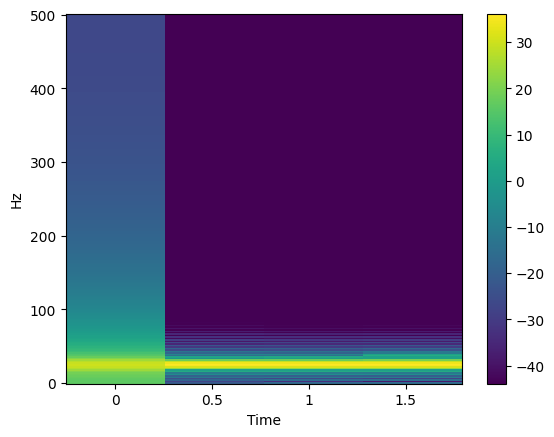

In [11]:
plot_spec(filtered, 1000)

In [12]:
y, sr = get_audio()
y = y/np.max(np.abs(y))

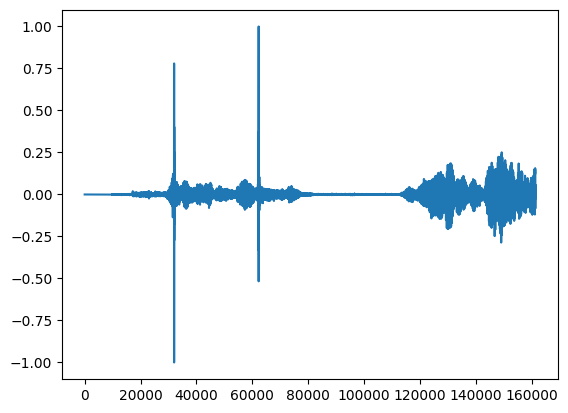

In [13]:
plt.plot(y)

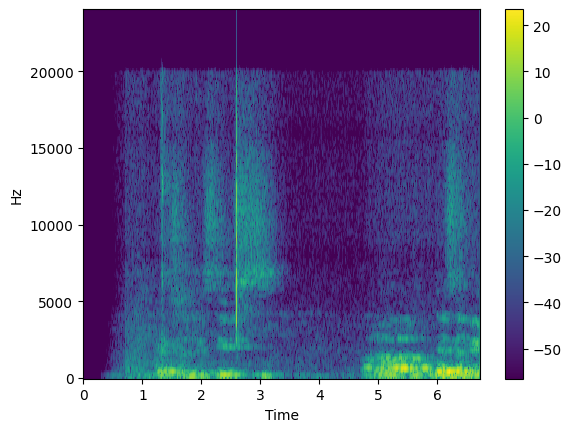

In [14]:
plot_spec(y, sr)

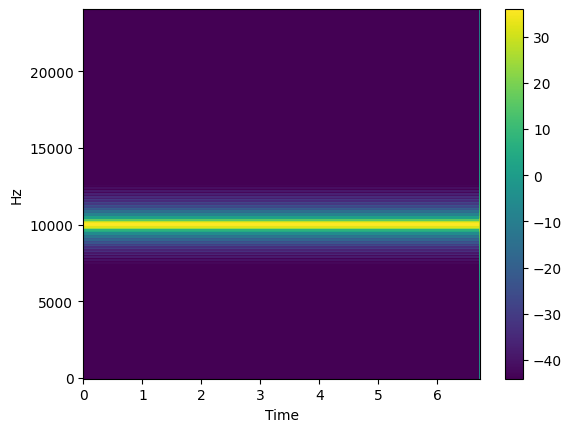

In [15]:
t = np.linspace(0, len(y)/sr, len(y))  # Generate 1000 samples in 1 sec
f = 10000
# Generate the signal containing f1 and f2
sig = np.sin(2*np.pi*f*t)
plot_spec(sig, sr)

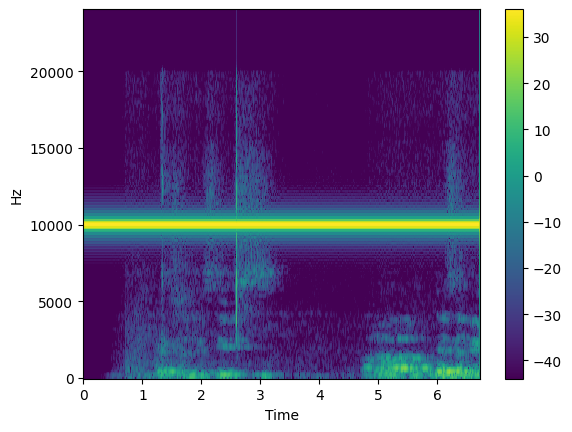

In [16]:
sig = y + sig
plot_spec(sig, sr)

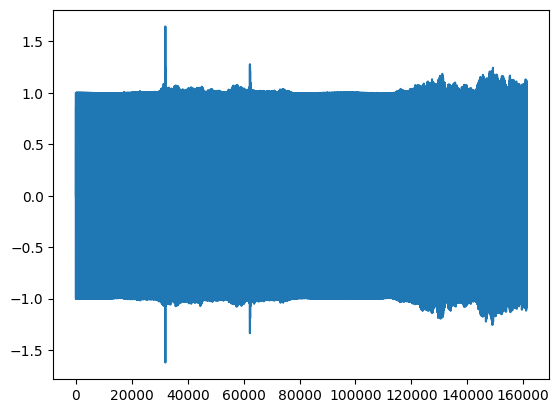

In [17]:
plt.plot(sig)

In [18]:
IPython.display.Audio(data=sig, rate=sr)

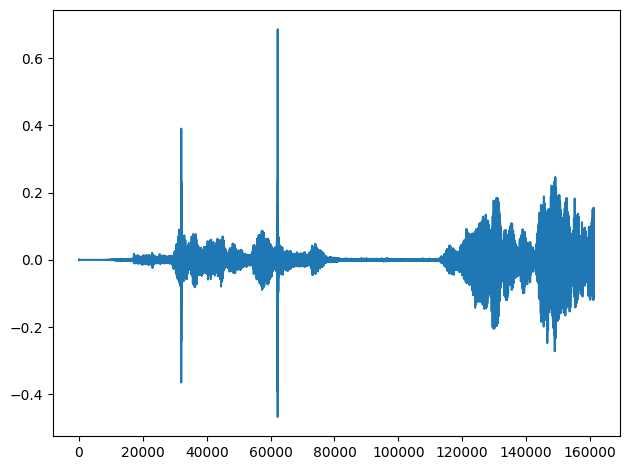

In [19]:
sos = signal.butter(50, 9000, 'lp', fs=sr, output='sos')
filtered = signal.sosfiltfilt(sos, sig)
plt.plot(filtered)
plt.tight_layout()
plt.show()

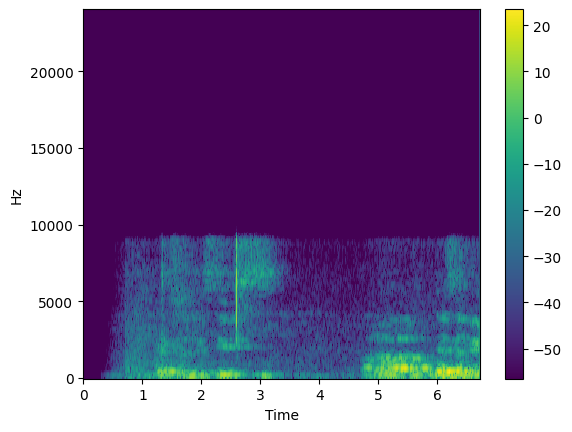

In [20]:
plot_spec(filtered, sr)

In [21]:
IPython.display.Audio(data=filtered, rate=sr)